## naver 영화 감성분석

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import re
from konlpy.tag import Okt

In [3]:
train_data= pd.read_table('../dataset/ratings_train.txt')
test_data= pd.read_table('../dataset/ratings_test.txt')

In [4]:
len(train_data), len(test_data)

(150000, 50000)

In [5]:
train_data['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

In [6]:
# 리뷰 중에 Null 값을 가진 샘플이 있는지 확인
print(train_data.isnull().values.any())
print(test_data.isnull().values.any())

True
True


In [7]:
# 어떤 열에 존재하는지 확인
print(train_data.isnull().sum())

id          0
document    5
label       0
dtype: int64


In [8]:
print(test_data.isnull().sum())

id          0
document    3
label       0
dtype: int64


In [9]:
# Null 값을 가진 샘플이 어느 인덱스의 위치에 존재하는지 확인
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [10]:
# Null 값을 가진 샘플을 제거
train_data=train_data.dropna(how='any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [11]:
test_data=test_data.dropna(how='any') # Null 값이 존재하는 행 제거
print(test_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [12]:
# 한글과 공백을 제외하고 모두 제거하는 정규 표현식
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [13]:
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0


## 훈련 데이터와 테스트 데이터에 대해 다음을 수행
- 토큰화와 불용어 제거
- 사이킷 런의 CountVectorizer가 처리할 수 있는 형태로 변환

In [14]:
stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()

In [15]:
from tqdm.notebook import tqdm
# 훈련 데이터
X_train=[]
for sentence in tqdm(train_data['document']):
    morphs = okt.morphs(sentence, stem=True) # 토큰화
    temp = ' '.join(morph for morph in morphs if not morph in stopwords)
    X_train.append(temp)

In [16]:
# 테스트 데이터
X_test=[]
for sentence in tqdm(test_data['document']):
    morphs = okt.morphs(sentence, stem=True) # 토큰화
    temp = ' '.join(morph for morph in morphs if not morph in stopwords)
    X_test.append(temp)

In [17]:
y_train=np.array(train_data['label'])
y_test=np.array(test_data['label'])

## 3. Naive Bayes 분류기로 분류하기

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB  # 다항분포 나이브 베이즈 모델
from sklearn.metrics import accuracy_score     # 정확도 계산

In [19]:
# DTM - Document Term Matrix
dtmvector = CountVectorizer()
X_train_dtm = dtmvector.fit_transform(X_train)
print(X_train_dtm.shape)

(149995, 42118)


In [20]:
# 사이킷 런에서 제공하는 나이브 베이즈 모델
model = MultinomialNB()
model.fit(X_train_dtm, y_train)

MultinomialNB()

In [21]:
# 테스트 데이터 DTM 형태로 변환
X_test_dtm = dtmvector.transform(X_test)
print(X_test_dtm.shape)

(49997, 42118)


In [22]:
predicted = model.predict(X_test_dtm) #테스트 데이터에 대한 예측
print("정확도: %.4f" % accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8248


## TF-IDF 적용

In [23]:
from sklearn.feature_extraction.text import TfidfTransformer

In [24]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(X_train_dtm)
tfidfv.shape

(149995, 42118)

In [25]:
model2 = MultinomialNB()
model2.fit(tfidfv, y_train)

MultinomialNB()

In [26]:
# DTM을 TF-IDF 행렬로 변환
tfidfv_test = tfidf_transformer.transform(X_test_dtm)

In [27]:
predicted = model2.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도: %.4f" % accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8231


## LSTM으로 분석

In [31]:
# 정수 인코딩

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
max_words = 35000
tokenizer = Tokenizer(num_words=max_words) # 상위 35,000개의 단어만 보존
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [32]:
X_train[:3]

[[50, 457, 16, 260, 660],
 [919, 459, 41, 599, 1, 214, 1455, 24, 965, 676, 19],
 [386, 2452, 25024, 2319, 5676, 2, 221, 9]]

In [33]:
# 전체 데이터의 길이 분포
print('리뷰의 최대 길이 :', max(len(s) for s in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.64700156671889


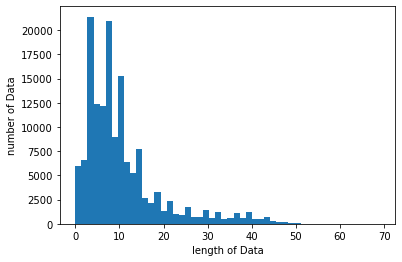

In [34]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [35]:
#  X_train과 X_test의 모든 샘플의 길이를 동일하게 30으로 셋팅
max_len=30
# 전체 데이터의 길이는 30으로 맞춘다.
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [36]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [28]:
import plaidml.keras
plaidml.keras.install_backend()
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential

In [42]:
model = Sequential()
model.add(Embedding(max_words, 100,input_length=30))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 100)           3500000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 3,617,377
Trainable params: 3,617,377
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
              metrics=['accuracy'])

In [44]:
from keras.callbacks import ModelCheckpoint
modelpath = "model/naver.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)

In [45]:
history = model.fit(X_train, y_train, epochs=4, batch_size=60,
                    validation_split=0.2, verbose=1, callbacks=[checkpointer])

Train on 119996 samples, validate on 29999 samples
Epoch 1/4
119996/119996 [==============================] - 1049s 9ms/step - loss: 0.3896 - acc: 0.8217 - val_loss: 0.3502 - val_acc: 0.8439

Epoch 00001: val_loss improved from inf to 0.35015, saving model to model/naver.hdf5
Epoch 2/4
119996/119996 [==============================] - 1033s 9ms/step - loss: 0.3286 - acc: 0.8555 - val_loss: 0.3327 - val_acc: 0.8524

Epoch 00002: val_loss improved from 0.35015 to 0.33274, saving model to model/naver.hdf5
Epoch 3/4
119996/119996 [==============================] - 1032s 9ms/step - loss: 0.3027 - acc: 0.8707 - val_loss: 0.3301 - val_acc: 0.8569

Epoch 00003: val_loss improved from 0.33274 to 0.33011, saving model to model/naver.hdf5
Epoch 4/4
119996/119996 [==============================] - 1034s 9ms/step - loss: 0.2811 - acc: 0.8822 - val_loss: 0.3278 - val_acc: 0.8572

Epoch 00004: val_loss improved from 0.33011 to 0.32781, saving model to model/naver.hdf5


In [46]:
# Best Model 선택
from keras.models import load_model
del model
model = load_model('model/naver.hdf5')

In [47]:

print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test, verbose=2)[1]))


 테스트 정확도: 0.8520


In [49]:
# 테스트셋
y_vloss = history.history['val_loss']
y_vacc = history.history['val_acc']
# 학습셋
y_loss = history.history['loss']
y_acc = history.history['acc']

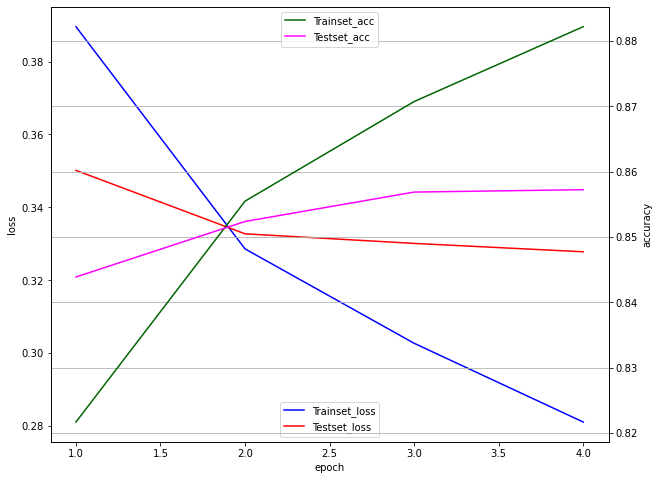

In [50]:
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='Trainset_loss')
ax0.plot(x_len, y_vloss, c="red", label='Testset_loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='Trainset_acc')
ax1.plot(x_len, y_vacc, c="magenta", label='Testset_acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center')
ax1.legend(loc='upper center')
plt.grid()
plt.show()